### Data Processing

In [2]:
import tifffile
import numpy as np
import torch.utils.data
import matplotlib.pyplot as plt
# from loss_metrics import tp_fp_fn
# flake8: noqa


def visualize_s2_img(s2_channel_paths):
    """
    Calculates and returns a 'SWIR' S2 false color composite ready for visualization.

    Args:
        s2_channel_paths (list of str): Paths to the ['B12', 'B7', 'B4'] bands of a S2 image.

    Returns:
        np.array: Image (H, W, 3) ready for visualization with e.g. plt.imshow(..)
    """
    img = []
    for path in s2_channel_paths:
        img.append(tifffile.imread(path))
    img = np.stack(img, axis=-1)
    return scale_S1_S2_img(img, sentinel=2)


def visualize_s1_img(path_vv, path_vh):
    """
    Calculates and returns a S1 false color composite ready for visualization.

    Args:
        path_vv (str): Path to the VV band.
        path_vh (str): Path to the VH band.

    Returns:
        np.array: Image (H, W, 3) ready for visualization with e.g. plt.imshow(..)
    """
    s1_img = np.stack((tifffile.imread(path_vv), tifffile.imread(path_vh)),
                      axis=-1)
    img = np.zeros((s1_img.shape[0], s1_img.shape[1], 3), dtype=np.float32)
    img[:, :, :2] = s1_img.copy()
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]
    s1_img = np.nan_to_num(s1_img)
    return scale_S1_S2_img(img, sentinel=1)


def scale_S1_S2_img(matrix, sentinel=2):
    """
    Returns a scaled (H,W,D) image which is more easily visually inspectable. Image is linearly scaled between
    min and max_value of by channel.
    Args:
        matrix (np.array): (H,W,D) image to be scaled
        sentinel (int, optional): Sentinel 1 or Sentinel 2 image? Determines the min and max values for scalin, defaults to 2.

    Returns:
        np.array: Image (H, W, 3) ready for visualization with e.g. plt.imshow(..)
    """
    w, h, d = matrix.shape
    min_values = np.array([100, 100, 100]) if sentinel == 2 else np.array(
        [-23, -28, 0.2])
    max_values = np.array([3500, 3500, 3500]) if sentinel == 2 else np.array(
        [0, -5, 1])

    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    matrix = (matrix - min_values[None, :]) / (max_values[None, :] -
                                               min_values[None, :])
    matrix = np.reshape(matrix, [w, h, d])

    matrix = matrix.clip(0, 1)
    return matrix


def mask_to_img(label, color_dict):
    """Recodes a (H,W) mask to a (H,W,3) RGB image according to color_dict"""
    mutually_exclusive = np.zeros(label.shape + (3, ), dtype=np.uint8)
    for key in range(1, len(color_dict.keys()) + 1):
        mutually_exclusive[label == key] = color_dict[key]
    return mutually_exclusive


class Sentinel1_Dataset(torch.utils.data.Dataset):

    def __init__(
        self,
        img_paths,
        mask_paths,
        transforms=None,
        min_normalize=-77,
        max_normalize=26,
    ):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transforms = transforms
        self.min_normalize = min_normalize
        self.max_normalize = max_normalize

    def __getitem__(self, idx):
        # Load in image
        arr_x = []
        for path in self.img_paths[idx]:
            arr_x.append(tifffile.imread(path))
        arr_x = np.stack(arr_x, axis=-1)
        # Min-Max Normalization
        arr_x = np.clip(arr_x, self.min_normalize, self.max_normalize)
        arr_x = (arr_x - self.min_normalize) / (self.max_normalize -
                                                self.min_normalize)

        sample = {"image": arr_x}

        # Load in label mask
        sample["mask"] = tifffile.imread(self.mask_paths[idx])

        # Apply Data Augmentation
        if self.transforms:
            sample = self.transforms(image=sample["image"],
                                     mask=sample["mask"])
        if sample["image"].shape[-1] < 20:
            sample["image"] = sample["image"].transpose((2, 0, 1))

        return sample

    def __len__(self):
        return len(self.img_paths)

    def visualize(self, how_many=1, show_specific_index=None):
        for _ in range(how_many):
            rand_int = np.random.randint(len(self.img_paths))
            if show_specific_index is not None:
                rand_int = show_specific_index
            print(self.img_paths[rand_int][0])
            f, axarr = plt.subplots(1, 3, figsize=(30, 9))
            axarr[0].imshow(
                visualize_s1_img(self.img_paths[rand_int][0],
                                 self.img_paths[rand_int][1]))
            sample = self.__getitem__(rand_int)

            img = sample["image"]
            axarr[0].set_title("FCC of original S1 image", fontsize=15)  # noqa
            axarr[1].imshow(img[0])  # Just visualize the VV band here
            axarr[1].set_title(
                f"VV band returned from the dataset, Min: {img.min():.4f}, Max: {img.max():.4f}",
                fontsize=15)
            if "mask" in sample.keys():
                axarr[2].set_title(
                    f"Corresponding water mask: {(sample['mask'] == 1).sum()} px",
                    fontsize=15)
                mask = mask_to_img(sample["mask"], {1: (0, 0, 255)})
                axarr[2].imshow(mask)
            plt.tight_layout()
            plt.show()

    def visualize_predictions(self,
                              model,
                              device,
                              how_many=1,
                              show_specific_index=None,
                              binary_threshold=0.5):
        model.eval()  # 确保模型处于评估模式
        with torch.no_grad():  # 关闭梯度计算
            for _ in range(how_many):
                idx = show_specific_index if show_specific_index is not None else np.random.randint(
                    len(self.img_paths))

                # 获取数据样本
                sample = self.__getitem__(idx)
                img = sample["image"]
                img_tensor = torch.from_numpy(img).unsqueeze(0).to(device)

                # 使用模型的 forward 方法获取预测概率
                output = model(img_tensor)
                pred_probs = torch.softmax(output,
                                           dim=1)[:, 1].to(device)  # 获取有水的概率
                # 将预测概率转换为二值化掩膜
                pred_mask_binary = (pred_probs > binary_threshold).long()

                # 计算二值化掩膜的 IOU
                tps, fps, fns = 0, 0, 0
                target_mask_tensor = torch.from_numpy(
                    sample["mask"]).long().to(device)
                tp, fp, fn = tp_fp_fn(pred_probs, target_mask_tensor)
                tps += tp
                fps += fp
                fns += fn
                iou_global = tps / (tps + fps + fns + EPS)
                print(f"Sample {idx} - IOU: {iou_global:.4f}")
                # 创建子图
                f, axarr = plt.subplots(1, 4, figsize=(40, 10))

                # 显示原始 S1 彩色合成图像
                s1_img = visualize_s1_img(self.img_paths[idx][0],
                                          self.img_paths[idx][1])
                axarr[0].imshow(s1_img)
                axarr[0].set_title("FCC of Original S1 Image", fontsize=15)

                # 显示 VV 波段图像
                axarr[1].imshow(img[0])
                axarr[1].set_title(
                    f"VV Band, Min: {img.min():.4f}, Max: {img.max():.4f}",
                    fontsize=15)

                # 显示真实水体掩膜（如果存在）
                if "mask" in sample:
                    mask = mask_to_img(sample["mask"],
                                       {1: (0, 0, 255)})  # 只关心类别 1
                    axarr[2].imshow(mask)
                    axarr[2].set_title(
                        f"Ground Truth Water Mask: {(sample['mask'] == 1).sum()} px",
                        fontsize=15)

                # 显示模型预测掩膜
                pred_mask_binary = pred_mask_binary.squeeze()
                pred_mask = pred_mask_binary.cpu().numpy()
                pred_mask_colored = mask_to_img(pred_mask, {1: (0, 255, 255)})
                axarr[3].imshow(pred_mask_colored)
                axarr[3].set_title("Model Prediction", fontsize=15)

                plt.tight_layout()
                plt.show()



### Loss Metrics

In [3]:
import torch
import torch.nn as nn


class XEDiceLoss(nn.Module):

    def __init__(self, alpha=0.5, EPS=1e-7):
        super().__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.alpha = alpha
        self.EPS = EPS

    def forward(self, preds, targets):
        xe_loss = self.cross_entropy(preds, targets)
        dice_loss = self.calculate_dice_loss(preds, targets)
        return self.alpha * xe_loss + (1 - self.alpha) * dice_loss

    def calculate_dice_loss(self, preds, targets):
        targets = targets.float()
        preds = torch.softmax(preds, dim=1)[:, 1]
        intersection = torch.sum(preds * targets)
        union = torch.sum(preds + targets)
        return 1 - (2.0 * intersection) / (union + self.EPS)


# Metric Calculation
def tp_fp_fn(preds, targets):
    tp = torch.sum(preds * targets)
    fp = torch.sum(preds) - tp
    fn = torch.sum(targets) - tp
    return tp.item(), fp.item(), fn.item()


### Model

In [4]:
import torch.nn as nn
import segmentation_models_pytorch as smp
# flake8: noqa: E501


class FloodwaterSegmentationModel(nn.Module):

    def __init__(
            self,
            model_name="Unet",  # 添加模型类型参数
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=2,
            classes=2):
        """
        初始化 FloodwaterSegmentationModel 类。

        Args:
            model_name (str): 选择的模型类型，如 'Unet', 'Linknet', 'FPN', 'DeepLabV3' 等。
            encoder_name (str): 使用的编码器名称。默认为 'resnet34'。
            encoder_weights (str): 编码器的预训练权重。默认为 'imagenet'。
            in_channels (int): 输入通道数。对于 Sentinel-1 数据，默认为 2 (VV 和 VH)。
            classes (int): 输出类别数。对于二分类问题，默认为 2。
        """
        super(FloodwaterSegmentationModel, self).__init__()

        # 根据模型类型选择相应的模型
        if model_name == "Unet":
            self.model = smp.Unet(encoder_name=encoder_name,
                                  encoder_weights=encoder_weights,
                                  in_channels=in_channels,
                                  classes=classes)
        elif model_name == "Linknet":
            self.model = smp.Linknet(encoder_name=encoder_name,
                                     encoder_weights=encoder_weights,
                                     in_channels=in_channels,
                                     classes=classes)
        elif model_name == "FPN":
            self.model = smp.FPN(encoder_name=encoder_name,
                                 encoder_weights=encoder_weights,
                                 in_channels=in_channels,
                                 classes=classes)
        elif model_name == "DeepLabV3":
            self.model = smp.DeepLabV3(encoder_name=encoder_name,
                                       encoder_weights=encoder_weights,
                                       in_channels=in_channels,
                                       classes=classes)
        elif model_name == "PSPNet":
            self.model = smp.PSPNet(encoder_name=encoder_name,
                                    encoder_weights=encoder_weights,
                                    in_channels=in_channels,
                                    classes=classes)
        elif model_name == "PAN":
            self.model = smp.PAN(encoder_name=encoder_name,
                                 encoder_weights=encoder_weights,
                                 in_channels=in_channels,
                                 classes=classes)
        else:
            raise ValueError(f"Unsupported model type: {model_name}")

    def forward(self, x):
        """
        定义模型的前向传播。

        Args:
            x (torch.Tensor): 输入数据。

        Returns:
            torch.Tensor: 模型的输出。
        """
        return self.model(x)


### Utils

In [5]:
import time
import torch
import glob
import numpy as np
import os
import segmentation_models_pytorch as smp
import torch.optim as optim
# flake8: noqa: E501


class AverageMeter(object):
    """
    Computes and stores the average and current value
    Adapted from https://github.com/pytorch/examples/blob/master/imagenet/main.py    # noqa: E501
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def to_device(data, device):
    if device.startswith('npu'):
        return {k: v.to(device, non_blocking=True) for k, v in data.items()}
    else:
        Warning("NPU Device is not supported")
    return data


def print_epoch_stats(phase,
                      epoch,
                      loss_meter,
                      batch_time,
                      data_time,
                      epoch_start_time,
                      iou=None):
    epoch_duration = time.time() - epoch_start_time
    if iou:
        print(
            f"Epoch: [{epoch}] {phase} - EpochT: {epoch_duration / 60:.1f} min, "
            f"Loss: {loss_meter.avg:.4f}")
        print(f"Global IOU: {iou:.4f}")
    else:
        print(
            f"Epoch: [{epoch}] {phase} - EpochT: {epoch_duration / 60:.1f} min, "
            f"BatchT: {batch_time.avg:.3f}s, DataT: {data_time.avg:.3f}s, Loss: {loss_meter.avg:.4f}"
        )


def save_model(save_dict, log_path):
    torch.save(save_dict, f"{log_path}/best_model.pt")


def create_data_loader(dataset, batch_size, shuffle, num_workers, pin_memory):
    return torch.utils.data.DataLoader(dataset,
                                       batch_size=batch_size,
                                       shuffle=shuffle,
                                       num_workers=num_workers,
                                       pin_memory=pin_memory)


def generate_paths(base_path, pattern, replacements):
    paths = sorted(glob.glob(f"{base_path}/{pattern}"))
    return [
        list(map(lambda r: path.replace(*r), replacements)) for path in paths
    ]


def split_data(paths, train_perc, val_perc):
    np.random.seed(17)
    np.random.shuffle(paths)
    n = len(paths)
    return {
        "train": paths[:int(train_perc * n)],
        "val": paths[int(train_perc * n):int((train_perc + val_perc) * n)],
        "test": paths[int((train_perc + val_perc) * n):]
    }


def download_smp_model(model_params):
    model = getattr(smp, model_params["model_name"])(
        encoder_name=model_params["encoder_name"],
        encoder_weights=model_params["encoder_weights"],
        in_channels=model_params["in_channels"],
        classes=model_params["classes"])
    print(
        f"Downloaded and cached {model_params['model_name']} model with {model_params['encoder_name']} encoder."
    )


def initialize_training(checkpoint_path, model, optimizer, scheduler_params,
                        train_mode):
    best_metric = 0
    best_metric_epoch = 0

    if train_mode == 'continue':
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optim_state_dict'])
        best_metric = checkpoint['iou']
        best_metric_epoch = checkpoint['epoch_num']
        optimizer.param_groups[0]['lr'] = 0.5 * optimizer.param_groups[0]['lr']

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                     **scheduler_params)

    return model, optimizer, scheduler, best_metric, best_metric_epoch


def load_model(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optim_state_dict'])
    best_metric = checkpoint['iou']
    best_metric_epoch = checkpoint['epoch_num']

    return model, optimizer, best_metric, best_metric_epoch

### Train

In [23]:
# from loss_metrics import tp_fp_fn
# from utils import AverageMeter, print_epoch_stats, to_device, save_model
import time
import torch


# flake8: noqa: E501
def train_epochs(model,
                 train_loader,
                 val_loader,
                 optimizer,
                 loss_func,
                 experiment_name,
                 log_path,
                 scheduler,
                 N_EPOCHS,
                 EARLY_STOP_THRESHOLD,
                 EARLY_STOP_PATIENCE,
                 DEVICE,
                 EPS,
                 start_epoch=1,
                 best_metric=0,
                 best_metric_epoch=0):

    early_stop_counter, best_val_early_stopping_metric = 0, 0
    start_time = time.time()  # 全局的开始时间
    best_model_state = None
    for curr_epoch_num in range(start_epoch, N_EPOCHS + 1):
        epoch_start_time = time.time()  # 记录当前 Epoch 的开始时间

        # 训练阶段
        model.train()
        train_loss, batch_time, data_time = AverageMeter(), AverageMeter(
        ), AverageMeter()
        end = time.time()

        for data in train_loader:
            data_time.update(time.time() - end)
            data = to_device(data, DEVICE)
            optimizer.zero_grad()
            preds = model(data["image"])
            loss = loss_func(preds, data["mask"].long())
            loss.backward()
            optimizer.step()
            train_loss.update(loss.item(), data["image"].size(0))
            batch_time.update(time.time() - end)
            end = time.time()

        print_epoch_stats('Train', curr_epoch_num, train_loss, batch_time,
                          data_time, epoch_start_time)

        # 验证阶段
        model.eval()
        val_loss, tps, fps, fns = AverageMeter(), 0, 0, 0
        with torch.no_grad():
            for data in val_loader:
                data = to_device(data, DEVICE)
                preds = model(data["image"])
                loss = loss_func(preds, data["mask"].long())
                val_loss.update(loss.item(), data["image"].size(0))
                preds_binary = (torch.softmax(preds, dim=1)[:, 1] > 0.5).long()
                tp, fp, fn = tp_fp_fn(preds_binary, data["mask"])
                tps += tp
                fps += fp
                fns += fn

        iou_global = tps / (tps + fps + fns + EPS)
        print_epoch_stats('Val', curr_epoch_num, val_loss, batch_time,
                          data_time, epoch_start_time, iou_global)

        # 保存Scheduler和Model
        if curr_epoch_num > EARLY_STOP_THRESHOLD:
            scheduler.step(iou_global)
        if iou_global > best_metric:
            best_metric, best_metric_epoch = iou_global, curr_epoch_num
            best_model_state = {
                "model_name": experiment_name,
                "epoch_num": curr_epoch_num,
                "model_state_dict": model.state_dict(),
                "optim_state_dict": optimizer.state_dict(),
                "iou": iou_global
            }
        if iou_global < best_val_early_stopping_metric:
            early_stop_counter += 1
        else:
            best_val_early_stopping_metric, early_stop_counter = iou_global, 0
        if early_stop_counter > EARLY_STOP_PATIENCE:
            print("Early Stopping")
            break

    # 训练结束后保存最佳模型
    if best_model_state:
        save_model(best_model_state, log_path)

    print(f"Best IOU: {best_metric} at Epoch: {best_metric_epoch}")

    # 返回有用的信息
    return {
        "model": model,
        "optimizer": optimizer,
        "scheduler": scheduler,
        "best_metric": best_metric,
        "best_metric_epoch": best_metric_epoch,
        "total_epochs": curr_epoch_num,
        "training_time": time.time() - start_time
    }



### Config

In [7]:
import torch
import torch_npu
import albumentations
# flake8: noqa

# 数据集和路径相关
BASE_PATH = "/home/HW/Pein/Floodwater/dataset"
TRAIN_PERCENTAGE = 0.8
VAL_PERCENTAGE = 0.1
TEST_PERCENTAGE = round(1 - TRAIN_PERCENTAGE - VAL_PERCENTAGE, 2)

# 数据预处理和增强
MIN_NORMALIZE = -77
MAX_NORMALIZE = 26
TRAIN_CROP_SIZE = 256
TARGET_SIZE = 256

# 数据增强配置
train_transforms = albumentations.Compose([
    albumentations.RandomCrop(TRAIN_CROP_SIZE, TRAIN_CROP_SIZE),
    # RandomResizedCrop(TARGET_SIZE, TARGET_SIZE, scale=(0.75, 1.0), p=0.5),
    albumentations.RandomBrightnessContrast(brightness_limit=0.2,
                                            contrast_limit=0.2),
    albumentations.GaussNoise(var_limit=(10, 50)),
    albumentations.RandomRotate90(),
    albumentations.HorizontalFlip(),
    albumentations.VerticalFlip(),
    albumentations.Resize(TARGET_SIZE, TARGET_SIZE),
])

# 模型和训练相关参数
NUM_WORKERS = 4
PIN_MEMORY = False
BATCH_SIZE = 16
EPS = 1e-7

PATIENCE = 6
N_EPOCHS = 200
LEARNING_RATE = 1e-4
EARLY_STOP_THRESHOLD = 10  # scheduler调整的阈值
EARLY_STOP_PATIENCE = PATIENCE * 5  # 早停的耐心周期

# 模型参数
MODEL_PARAMS = {
    "model_name": "PAN",
    "encoder_name": "resnet101",
    "encoder_weights": "imagenet",
    "in_channels": 2,
    "classes": 2
}

# 设备和日志相关
DEVICE = 'npu:1' if torch.npu.is_available() else 'cpu'
EXPERIMENT_NAME = f"{MODEL_PARAMS['model_name']}-{MODEL_PARAMS['encoder_name']}-b{BATCH_SIZE}"
LOG_PATH = f"/home/HW/Pein/Floodwater/SMP/trained_models/{EXPERIMENT_NAME}"

# 训练模式：'new' 从头开始，'continue' 从checkpoint继续
TRAIN_MODE = 'continue'  # 或 'continue'

# 如果是 'tuning' 模式，指定checkpoint路径
CHECKPOINT_PATH = '/home/HW/Pein/Floodwater/SMP/trained_models/PAN-resnet101-b16/best_model.pt'  #当前最好的模型,IOU:0.85


### Main

In [12]:
import torch_npu
import torch
import albumentations
import torch.optim
import torch.utils.data
import sys
import os
import torch.optim as optim
import segmentation_models_pytorch as smp
import time
# from utils import (AverageMeter, print_epoch_stats, save_model, to_device,
#                    create_data_loader, generate_paths, split_data,
#                    download_smp_model, initialize_training, load_model)
# from data_processing import Sentinel1_Dataset
# from loss_metrics import XEDiceLoss, tp_fp_fn
# from train import train_epochs
# from model import FloodwaterSegmentationModel
# from config import *
# flake8: noqa

# 定义文件路径替换
label_replacements = [("LabelWater.tif", "LabelWater.tif")]
image_replacements = [("LabelWater.tif", "VV.tif"),
                      ("LabelWater.tif", "VH.tif")]

# 生成文件路径
label_paths = generate_paths(BASE_PATH, "chips/*/s1/*/LabelWater.tif",
                             label_replacements)
image_paths = generate_paths(BASE_PATH, "chips/*/s1/*/LabelWater.tif",
                             image_replacements)

# 数据拆分
label_splits = split_data(label_paths, TRAIN_PERCENTAGE, VAL_PERCENTAGE)
image_splits = split_data(image_paths, TRAIN_PERCENTAGE, VAL_PERCENTAGE)

# Sentinel1_Dataset初始化
train_dataset = Sentinel1_Dataset(image_splits['train'],
                                  label_splits['train'],
                                  transforms=train_transforms,
                                  min_normalize=MIN_NORMALIZE,
                                  max_normalize=MAX_NORMALIZE)
val_dataset = Sentinel1_Dataset(image_splits['val'],
                                label_splits['val'],
                                transforms=None,
                                min_normalize=MIN_NORMALIZE,
                                max_normalize=MAX_NORMALIZE)
test_dataset = Sentinel1_Dataset(image_splits['test'],
                                 label_splits['test'],
                                 transforms=None,
                                 min_normalize=MIN_NORMALIZE,
                                 max_normalize=MAX_NORMALIZE)

# 其他设置（NPU、文件夹创建、模型下载等）
os.makedirs(LOG_PATH, exist_ok=True)
download_smp_model(MODEL_PARAMS)

#NPU设置
torch.npu.set_device(DEVICE)
if torch.npu.is_available() and DEVICE.startswith('npu'):
    print(f'Using NPU: {DEVICE} ...')
else:
    print('Using CPU ...')

# 打印基本信息
print(f"""
TRAIN_CROP_SIZE = {TRAIN_CROP_SIZE}
TARGET_SIZE = {TARGET_SIZE}
NUM_WORKERS = {NUM_WORKERS}
PIN_MEMORY = {PIN_MEMORY}
BATCH_SIZE = {BATCH_SIZE}
EPS = {EPS}
EXPERIMENT_NAME = '{EXPERIMENT_NAME}'
ENCODER_NAME = '{MODEL_PARAMS['encoder_name']}'
MODEL_NAME = '{MODEL_PARAMS['model_name']}'
ENCODER_WEIGHTS = '{MODEL_PARAMS['encoder_weights']}'
IN_CHANNELS = {MODEL_PARAMS['in_channels']}
CLASSES = {MODEL_PARAMS['classes']}
PATIENCE = {PATIENCE}
N_EPOCHS = {N_EPOCHS}
LEARNING_RATE = {LEARNING_RATE}
EARLY_STOP_THRESHOLD = {EARLY_STOP_THRESHOLD}
EARLY_STOP_PATIENCE = {EARLY_STOP_PATIENCE}
""")

# 加载数据
train_loader = create_data_loader(train_dataset,
                                  BATCH_SIZE,
                                  shuffle=True,
                                  num_workers=NUM_WORKERS,
                                  pin_memory=PIN_MEMORY)
val_loader = create_data_loader(val_dataset,
                                BATCH_SIZE,
                                shuffle=False,
                                num_workers=NUM_WORKERS,
                                pin_memory=PIN_MEMORY)
test_loader = create_data_loader(test_dataset,
                                 BATCH_SIZE,
                                 shuffle=False,
                                 num_workers=NUM_WORKERS,
                                 pin_memory=PIN_MEMORY)


Downloaded and cached PAN model with resnet101 encoder.
Using NPU: npu:1 ...

TRAIN_CROP_SIZE = 256
TARGET_SIZE = 256
NUM_WORKERS = 4
PIN_MEMORY = False
BATCH_SIZE = 16
EPS = 1e-07
EXPERIMENT_NAME = 'PAN-resnet101-b16'
ENCODER_NAME = 'resnet101'
MODEL_NAME = 'PAN'
ENCODER_WEIGHTS = 'imagenet'
IN_CHANNELS = 2
CLASSES = 2
PATIENCE = 6
N_EPOCHS = 200
LEARNING_RATE = 0.0001
EARLY_STOP_THRESHOLD = 10
EARLY_STOP_PATIENCE = 30



In [13]:
# 模型初始化
model = FloodwaterSegmentationModel(**MODEL_PARAMS).to(DEVICE)
loss_func = XEDiceLoss().to(DEVICE)

# 优化器初始化
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Scheduler 参数
scheduler_params = {
    "mode": "min",
    "factor": 0.1,
    "patience": PATIENCE,
    "verbose": True
}

# 使用 initialize_training 函数初始化训练环境
model, optimizer, scheduler, best_metric, best_metric_epoch = initialize_training(
    CHECKPOINT_PATH, model, optimizer, scheduler_params, TRAIN_MODE)

if TRAIN_MODE == 'continue':
    print(
        f"Continuing training: Learning rate: {optimizer.param_groups[0]['lr']}, Best IOU: {best_metric} at epoch: {best_metric_epoch}"
    )

# 早停相关变量初始化
early_stop_counter = 0
start_epoch = best_metric_epoch if TRAIN_MODE == 'continue' else 1


Continuing training: Learning rate: 4.8828125e-09, Best IOU: 0.8465910460954731 at epoch: 111


In [ ]:
# 开始训练
train_result = train_epochs(model, train_loader, val_loader, optimizer,
                            loss_func, EXPERIMENT_NAME, LOG_PATH, scheduler,
                            N_EPOCHS, EARLY_STOP_THRESHOLD,
                            EARLY_STOP_PATIENCE, DEVICE, EPS, start_epoch,
                            best_metric, best_metric_epoch)

# 打印或处理返回的信息
print('--' * 20)
print("Training Completed:")
print(f"Total Training Time: {train_result['training_time'] / 60} minutes")
# print(f"Total Training Time: {train_result['training_time']} seconds")


## Visualization

Sample 81 - IOU: 0.5653


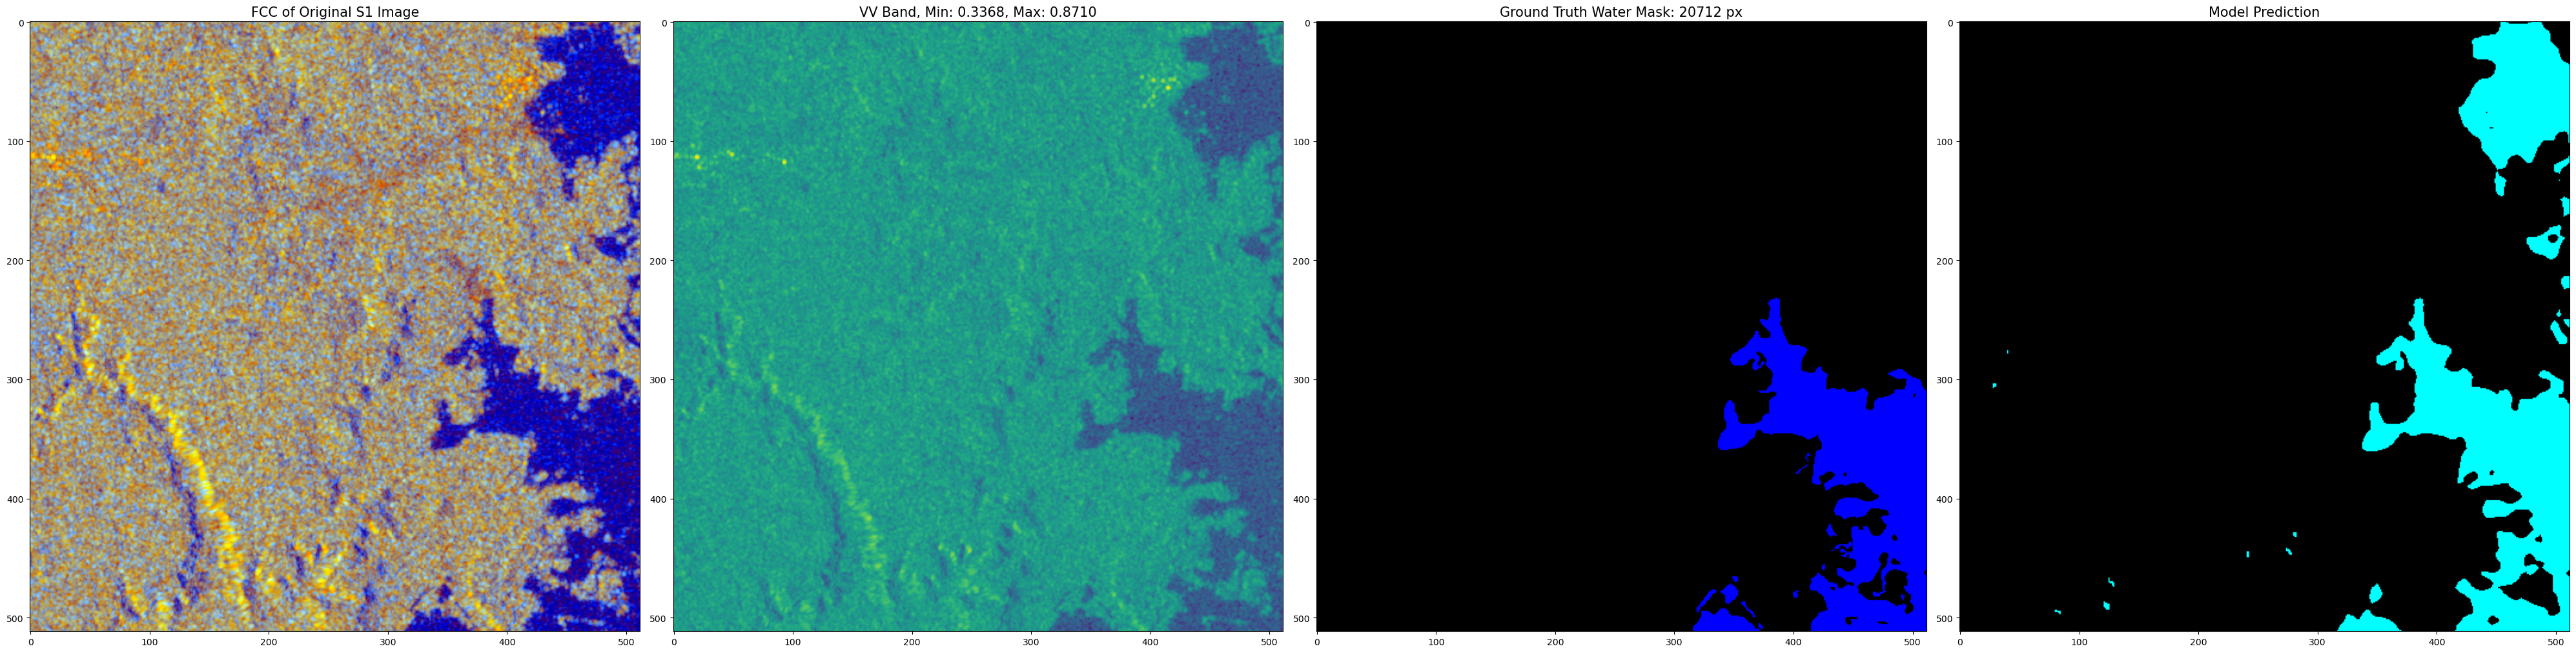

In [14]:
test_dataset.visualize_predictions(model,
                                   DEVICE,
                                   how_many=1,
                                   show_specific_index=81)

In [31]:
def soft_iou(preds, targets, EPS=1e-6):
    # 预测的概率分布 (使用softmax获得每个像素的概率)
    preds_probs = torch.softmax(preds, dim=1)[:, 1]  # 取第二类（假设是水体）的概率

    # 计算交集和并集
    intersection = torch.sum(preds_probs * targets)
    union = torch.sum(preds_probs) + torch.sum(targets) - intersection

    # 计算IOU
    iou = (intersection + EPS) / (union + EPS)
    return iou.item()


def adjust_threshold_and_evaluate(model, train_loader, val_loader, test_loader,
                                  threshold_range, DEVICE, EPS):
    model.eval()
    best_threshold, best_threshold_iou = 0, 0

    # 微调阈值 - 使用验证集
    with torch.no_grad():
        for threshold in threshold_range:
            tps, fps, fns = 0, 0, 0
            prob_iou_total = 0  
            sample_count = 0  

            for data in val_loader:
                data = to_device(data, DEVICE)
                preds = model(data["image"])
                preds_binary = (torch.softmax(preds, dim=1)[:, 1]
                                > threshold).long()
                tp, fp, fn = tp_fp_fn(preds_binary, data["mask"])
                tps += tp
                fps += fp
                fns += fn

            iou = tps / (tps + fps + fns + EPS)
            if iou > best_threshold_iou:
                best_threshold, best_threshold_iou = threshold, iou

    print(
        f"Best Threshold on Validation Set: {best_threshold:.4f}, IOU: {best_threshold_iou:.4f}"
    )

    # 计算并打印每个数据集上的IOU
    for loader, name in zip([train_loader, val_loader, test_loader],
                            ["Train", "Validation", "Test"]):
        tps, fps, fns = 0, 0, 0
        prob_tps, prob_fps, prob_fns = 0, 0, 0
        with torch.no_grad():
            for data in loader:
                data = to_device(data, DEVICE)
                preds = model(data["image"])

                # 计算基于最佳阈值的二分类后的IOU
                preds_binary = (torch.softmax(preds, dim=1)[:, 1]
                                > best_threshold).long()
                tp, fp, fn = tp_fp_fn(preds_binary, data["mask"])
                tps += tp
                fps += fp
                fns += fn

                # 计算基于概率的IOU
                prob_iou = soft_iou(preds, data["mask"].float())  # 确保mask是浮点型
                prob_iou_total += prob_iou
                sample_count += 1

        iou = tps / (tps + fps + fns + EPS)
        prob_iou_avg = prob_iou_total / sample_count  # 计算平均IOU
        print(
            f"{name} Set - Binary Threshold IOU: {iou:.4f}, Probability IOU: {prob_iou:.4f}"
        )


### Tune binary threshold

In [32]:
threshold_range = np.arange(0.3, 0.5, 0.1) 
adjust_threshold_and_evaluate(model, train_loader, val_loader, test_loader,
                              threshold_range, DEVICE, EPS)


Best Threshold on Validation Set: 0.4000, IOU: 0.8425
Train Set - Binary Threshold IOU: 0.4547, Probability IOU: 0.2239
Validation Set - Binary Threshold IOU: 0.8425, Probability IOU: 0.6297
Test Set - Binary Threshold IOU: 0.8029, Probability IOU: 0.9170
